In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.models as models
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy

import os
import sys
# os.path.dirname(sys.executable)
# sys.path.append('/kuacc/users/baristopal20/SSuperGAN/')

In [3]:
from data.datasets.random_dataset import RandomDataset
from data.datasets.golden_panels import GoldenPanelsDataset
from data.augment import get_PIL_image

from networks.ssupervae import SSuperVAE
from training.vae_trainer import VAETrainer
from utils.config_utils import read_config, Config
from utils.logging_utils import *
from utils.plot_utils import *
from utils import pytorch_util as ptu

from configs.base_config import *
from functional.losses.elbo import elbo

In [4]:
config = read_config(Config.SSUPERVAE)
golden_age_config = read_config(Config.GOLDEN_AGE)
ptu.set_gpu_mode(True)

In [6]:
net = SSuperVAE(config.backbone, 
                latent_dim=config.latent_dim, 
                embed_dim=config.embed_dim,
                use_lstm=True,
                seq_size=config.seq_size,
                decoder_channels=config.decoder_channels,
                gen_img_size=config.image_dim,
                lstm_hidden=config.lstm_hidden,
                lstm_dropout=config.lstm_dropout,
                fc_hidden_dims=config.fc_hidden_dims,
                fc_dropout=config.fc_dropout,
                num_lstm_layers=config.num_lstm_layers,
                masked_first=config.masked_first).cuda() 

if config.parallel == True:
        net = nn.DataParallel(net)

load_path = "/scratch/users/gsoykan20/projects/AF-GAN/playground/ssupervae/ckpts/lstm_ssupervae_model-checkpoint-epoch99.pth"
net.load_state_dict(torch.load(load_path)['model_state_dict'])
net = net.cuda().eval()

Loaded pretrained weights for efficientnet-b5


In [6]:
"""
pnet = SSuperVAE(config.backbone, 
                latent_dim=config.latent_dim, 
                embed_dim=config.embed_dim,
                use_lstm=False,
                seq_size=config.seq_size,
                decoder_channels=config.decoder_channels,
                gen_img_size=config.image_dim,
                lstm_hidden=config.lstm_hidden,
                lstm_dropout=config.lstm_dropout,
                fc_hidden_dims=config.fc_hidden_dims,
                fc_dropout=config.fc_dropout,
                num_lstm_layers=config.num_lstm_layers,
                masked_first=config.masked_first).cuda() 

l_path = "/userfiles/comics_grp/pretrained_models/plain_ssupervae_epoch85.pth"
pnet.load_state_dict(torch.load(l_path)['model_state_dict'])
pnet = pnet.cuda().eval()
"""

'\npnet = SSuperVAE(config.backbone, \n                latent_dim=config.latent_dim, \n                embed_dim=config.embed_dim,\n                use_lstm=False,\n                seq_size=config.seq_size,\n                decoder_channels=config.decoder_channels,\n                gen_img_size=config.image_dim,\n                lstm_hidden=config.lstm_hidden,\n                lstm_dropout=config.lstm_dropout,\n                fc_hidden_dims=config.fc_hidden_dims,\n                fc_dropout=config.fc_dropout,\n                num_lstm_layers=config.num_lstm_layers,\n                masked_first=config.masked_first).cuda() \n\nl_path = "/userfiles/comics_grp/pretrained_models/plain_ssupervae_epoch85.pth"\npnet.load_state_dict(torch.load(l_path)[\'model_state_dict\'])\npnet = pnet.cuda().eval()\n'

In [10]:
dataset = GoldenPanelsDataset(golden_age_config.panel_path,
                              golden_age_config.sequence_path, 
                              golden_age_config.panel_dim,
                              config.image_dim, 
                              augment=False, 
                              shuffle=False,
                              mask_val=1, # mask with white color for 1 and black color for 0
                              mask_all=False, # masks faces from all panels and returns all faces
                              return_mask=True,
                              return_mask_coordinates=True,
                              train_test_ratio=golden_age_config.train_test_ratio,
                              train_mode=False,
                              limit_size=-1)

dataset.data = [
    [['593/29_6.jpg', '593/30_0.jpg', '593/30_1.jpg'], [[[29, 0, 532, 503], [183, 51, 281, 149]], [[7, 0, 543, 536], [90, 229, 206, 345]], 
                                                        [[15, 0, 552, 537], [186, 192, 298, 304]]]], # animal
    
    [['3918/34_0.jpg', '3918/34_1.jpg', '3918/34_2.jpg'], [[[31, 0, 570, 539], [117, 278, 239, 400]], [[0, 14, 506, 520], [155, 181, 195, 221]],
                                                           [[18, 0, 514, 496], [121, 274, 229, 382]]]], # woman
    
    [['211/20_0.jpg', '211/20_1.jpg', '211/20_2.jpg'], [[[612, 0, 1165, 553], [1041, 188, 1105, 252]], [[20, 0, 589, 569], [386, 189, 462, 265]],
                                                        [[39, 0, 595, 556], [95, 175, 289, 369]]]], # bad man
    
    [['915/30_1.jpg', '915/30_2.jpg', '915/30_3.jpg'], [[[0, 7, 419, 426], [127, 205, 255, 333]], [[0, 59, 356, 415], [160, 258, 282, 380]],
                                                        [[0, 82, 264, 346], [89, 228, 193, 332]]]], # good man

    [['3513/21_5.jpg', '3513/21_6.jpg', '3513/22_0.jpg'], [[[59, 0, 611, 552], [199, 180, 369, 350]], [[0, 17, 533, 550], [90, 206, 164, 280]],
                                                           [[0, 69, 395, 464], [73, 230, 185, 342]]]], # good man

    [['2464/73_4.jpg', '2464/73_5.jpg', '2464/73_6.jpg'], [[[131, 0, 743, 612], [225, 206, 361, 342]], [[168, 0, 890, 722], [602, 316, 658, 372]],
                                                           [[73, 0, 740, 667], [185, 266, 331, 412]]]], # mask problem
]

data_loader = DataLoader(dataset, batch_size=1, shuffle=False)

dl_iter = iter(data_loader)

In [8]:
def create_global_pred_gt_images(
                                     x,
                                     y,
                                     mu_x,
                                     mask_coordinates):
        # Preparing for Fine Generator
        B, S, C, W, H = x.shape
        last_panel_gts = ptu.zeros(B, C, H, W)
        panel_with_generation = ptu.zeros_like(last_panel_gts)
        for i in range(len(x)):
            last_panel = x[i, -1, :, :, :]
            output_merged_last_panel = deepcopy(last_panel)

            last_panel_face = y[i, :, :, :]
            last_panel_output_face = mu_x[i, :, :, :]

            mask_coordinates_n = mask_coordinates[i]

            original_w = abs(mask_coordinates_n[0] - mask_coordinates_n[1])
            original_h = abs(mask_coordinates_n[2] - mask_coordinates_n[3])

            # inserting original face to last panel
            modified = last_panel_face.view(1, *last_panel_face.size())
            interpolated_last_panel_face_batch = torch.nn.functional.interpolate(modified,
                                                                                 size=(original_w, original_h))
            interpolated_last_panel_face = interpolated_last_panel_face_batch[0]
            last_panel[:,
            mask_coordinates_n[0]: mask_coordinates_n[1],
            mask_coordinates_n[2]: mask_coordinates_n[3]] = interpolated_last_panel_face
            last_panel_gts[i, :, :, :] = last_panel

            # inserting output face to last panel
            modified = last_panel_output_face.view(1, *last_panel_output_face.size())
            interpolated_last_panel_face_batch = torch.nn.functional.interpolate(modified,
                                                                                 size=(original_w, original_h))
            interpolated_last_panel_face = interpolated_last_panel_face_batch[0]
            output_merged_last_panel[:, mask_coordinates_n[0]: mask_coordinates_n[1],
            mask_coordinates_n[2]: mask_coordinates_n[3]] = interpolated_last_panel_face
            panel_with_generation[i, :, :, :] = output_merged_last_panel

        return panel_with_generation, last_panel_gts

def plot_panels_and_faces(panels_tensor, face_tensor, recon_face_tensor, global_recon_tensor):
    
    global_recon_tensor = get_PIL_image(global_recon_tensor[0,:,:,:])
    y_recon = get_PIL_image(recon_face_tensor[0,:,:,:])
    y = get_PIL_image(face_tensor[0,:,:,:])
    
    panels = []
    for i in range(panels_tensor.shape[1]):
        panels.append(get_PIL_image(panels_tensor[0,i,:,:,:]))
    
    w, h = panels[0].size
    wsize, hsize =  2, 1 # panels_tensor.shape[1] + 3, 1
    w = (w + 100) * wsize
    h = (h + 50) * hsize
    
    px = 1/plt.rcParams['figure.dpi']
    f, ax = plt.subplots(hsize, wsize)
    f.set_size_inches(w*px, h*px)
    
    #for i in range(len(panels)):
     #   ax[i].imshow(panels[i])
      #  ax[i].title.set_text("Panel" + str(i+1))
       
    ax[-2].imshow(global_recon_tensor)
    ax[-2].title.set_text("Global Recon")
    
    ax[-1].imshow(y_recon)
    ax[-1].title.set_text("Recon")
    
   # ax[-1].imshow(y)
   # ax[-1].title.set_text("Original")
    
    
    
    plt.show()
    return plt

## Masking Test

In [10]:
x, y, z, c = next(dl_iter)
plot_panels_and_faces(x, y, z.unsqueeze(0).repeat(1, 3, 1, 1))

IndexError: too many indices for tensor of dimension 2

## Model Result Test

[INFO] Example: 0


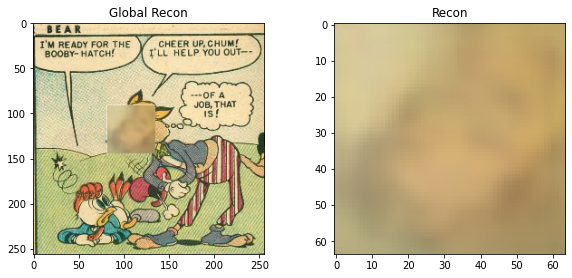

[INFO] Example: 1


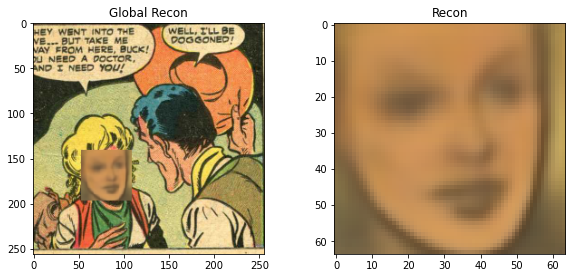

[INFO] Example: 2


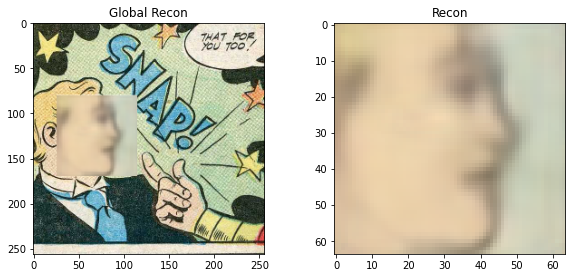

[INFO] Example: 3


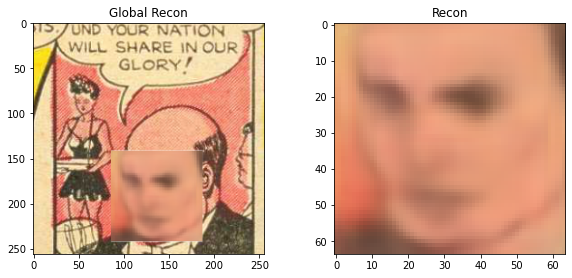

[INFO] Example: 4


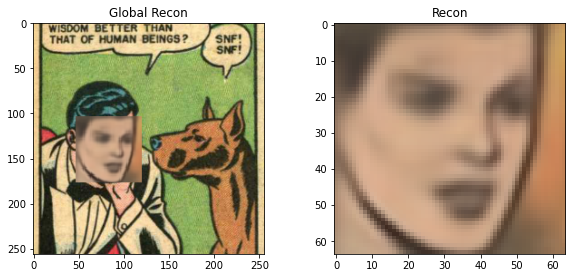

[INFO] Example: 5


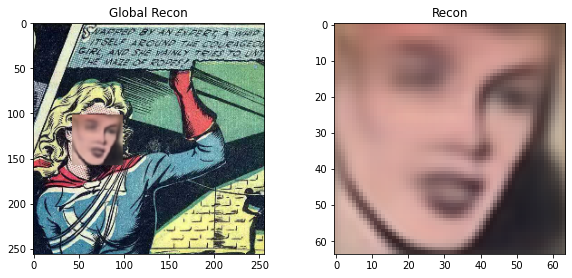

In [11]:
ctr, limit = 0, 6

for i in range(limit):
    x, y, z, c = next(dl_iter)
    
    with torch.no_grad():
        _, _, _, y_recon, _ = net(x=x.cuda())   
      #   _, _, _, py_recon, _ = pnet(x.cuda()) 
    print("[INFO] Example:", i)
    generated, gt = create_global_pred_gt_images(x, y, y_recon, c)
    plot_panels_and_faces(x, y, y_recon.cpu(), generated.cpu())
    # plot_panels_and_faces(x, y, py_recon.cpu())

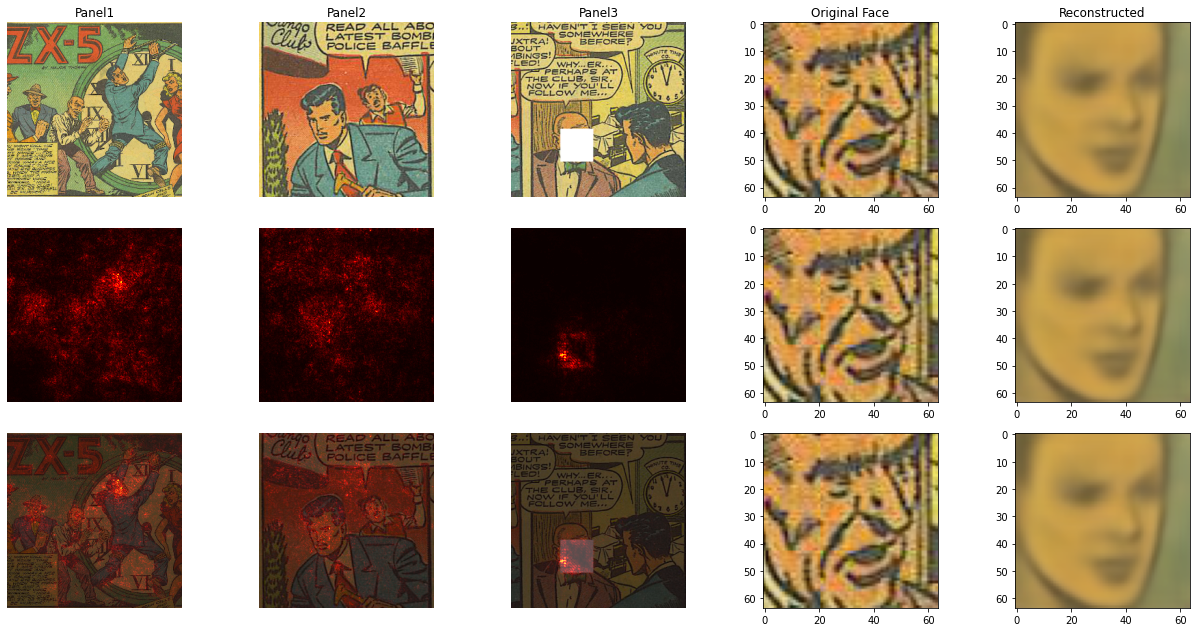

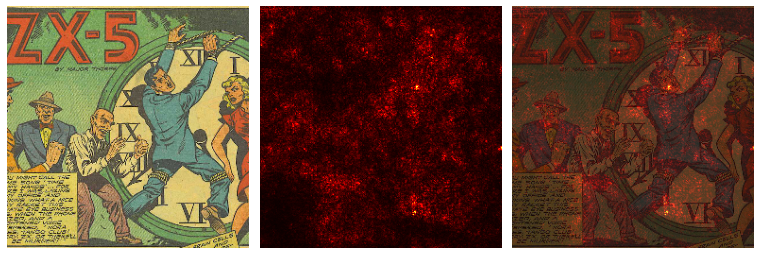

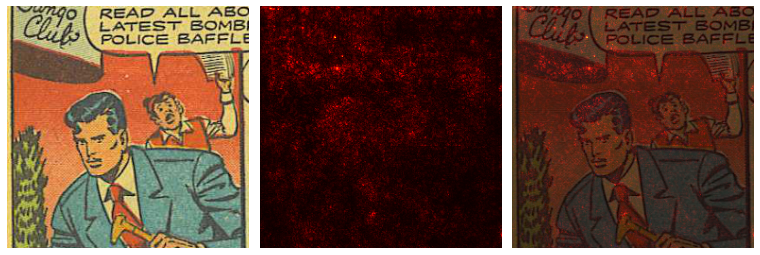

LSTM(1024, 1024)

In [38]:
import copy

net.module.encoder.lstm.train()

x, y, z = next(dl_iter)

draw_saliency(net, copy.deepcopy(x), copy.deepcopy(y))
# draw_saliency(pnet, copy.deepcopy(x), copy.deepcopy(y))

draw_backbone_saliency(net.module.encoder.embedder, copy.deepcopy(x), 0)
# draw_backbone_saliency(pnet.encoder.embedder, copy.deepcopy(x), 0)

draw_backbone_saliency(net.module.encoder.embedder, copy.deepcopy(x), 1)
# draw_backbone_saliency(pnet.encoder.embedder, copy.deepcopy(x), 1)

net.module.encoder.lstm.eval()

In [7]:
import torch
import torch.nn.functional as F

def kl_loss_old(z, mu, std):
    p = torch.distributions.Normal(torch.zeros_like(mu), torch.ones_like(std))
    q = torch.distributions.Normal(mu, std)
    log_q = q.log_prob(z)
    log_p = p.log_prob(z)
    return F.kl_div(log_p, log_q, reduction="batchmean", log_target=True)


def kl_loss_new(z, mu, std):
    p = torch.distributions.Normal(torch.zeros_like(mu), torch.ones_like(std))
    q = torch.distributions.Normal(mu, std)

    kl_dvergence = torch.distributions.kl.kl_divergence(q,p)
    kl_loss = kl_dvergence.sum(1).mean()
    return kl_loss

In [8]:
z = torch.randn(1, 256)
mu = torch.randn(1, 256)
std = torch.randn(1, 256).exp()

print(kl_loss_old(z, mu, std))
print(kl_loss_new(z, mu, std))

tensor(15.4770)
tensor(1199.8945)
